In [1]:
cd ~/microbiome_rnn/

/Volumes/export/isn/mwiest/microbiome_rnn


In [2]:
from __future__ import print_function
import os
import torch
import numpy as np
import pandas as pd
import sys
from otu_handler import OTUHandler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from scipy.stats.mstats import zscore
import matplotlib.gridspec as gridspec
from matplotlib.cm import ScalarMappable
from scipy.spatial.distance import cosine
import seaborn as sns
%matplotlib inline

In [39]:
def complete_and_multiindex_df(df, split_char):
    default_tax = ['k__', 'p__', 'c__', 'o__', 'f__', 'g__', 's__']
    s = list(df.index.values)
    lt = [list(ls.split(split_char)) for ls in s]
    lt = [[ltii.strip() for ltii in lti] for lti in lt]
    for l in lt:
        if len(l) < len(default_tax):
            l += default_tax[-(len(default_tax)-len(l)):]

    ltn = pd.DataFrame(np.array(lt))
    ltn.index = df.index
    ltn.columns = default_tax
    combined = pd.concat((df, ltn), axis=1)
    combined.set_index(default_tax, inplace=True)
    return combined


In [40]:
input_dir = 'all_studies_reduced_62/'
test_dir = 'all_studies_reduced_62_test/'

input_files = [os.path.join(input_dir, f) for f in os.listdir(input_dir)]
test_files = [os.path.join(test_dir, f) for f in os.listdir(test_dir)]
# Join the test and train files.
files = input_files + test_files
oh = OTUHandler(files)

# This is a more readable naming convention for the files. 
# Basically rob knight is the last two samples.
file_labs = ['Donor$_0$', 'Donor$_1$', 'Donor$_{2, 0}$', 'Donor$_{2, 1}$', 'Donor$_3$']

# Group the strains by taxonomy levels and define a colormap

In [41]:
# How many taxonomy levels to include in the plots. 
# Higher numbers results in a a larger number of strains, ie less grouping
levels = 3
join_char = '\n'
split_char = ';'
# Reindex the dataframes
multi_samples = [complete_and_multiindex_df(s, split_char) for s in oh.samples]

In [42]:

# Get various pieces of data about the taxonomy.
grouped = [ms.groupby(level=list(range(0, levels))) for ms in multi_samples]
# Taxonomy names
labels = [join_char.join(c) for c in grouped[0].count().index]


In [43]:
# Get color labels so that we can color the points based on taxonomy.
labs = [join_char.join(c[0:levels]) for c in multi_samples[0].index.values]
full_labs = [join_char.join(c.split(split_char)) for c in oh.samples[0].index.values]

unique_ints = list(range(len(labels)))
unique_int_lookup = dict(zip(labels, unique_ints))
labs_to_ints = [unique_int_lookup[l] for l in labs]
print('There are {} distinct groups'.format(len(labels)))


There are 13 distinct groups


In [44]:
# Now define the colormap
num_colors = len(list(set(labs)))
cmap = plt.cm.get_cmap('tab20', num_colors)
colors = cmap(np.linspace(0, 1, num_colors))
color_lookup = dict(zip(labels, colors))
colors_to_plot = [color_lookup[l] for l in labs]

In [45]:
# Just a little math to figure out the dimensions of the plots. Because the number of samples could be variable.
num_cols = 2
num_rows = int(len(files) / num_cols) + (len(files) % num_cols)

subplot_height = num_rows * 5
subplot_width = num_cols * 7.5
colorbar_height = min(1, 2 / (1.0 * num_rows))
colorbar_start = max(0, (num_rows - 2) / 5.0)

# Look at prevalence of different strains
By sample we are going to plot the count of each strain, their averages, and sum.

In [46]:

counts = [g.count().values[:, 0] for g in grouped]
means = [g.mean().values[:, 0] for g in grouped]
sums = [g.sum().values[:, 0] for g in grouped]

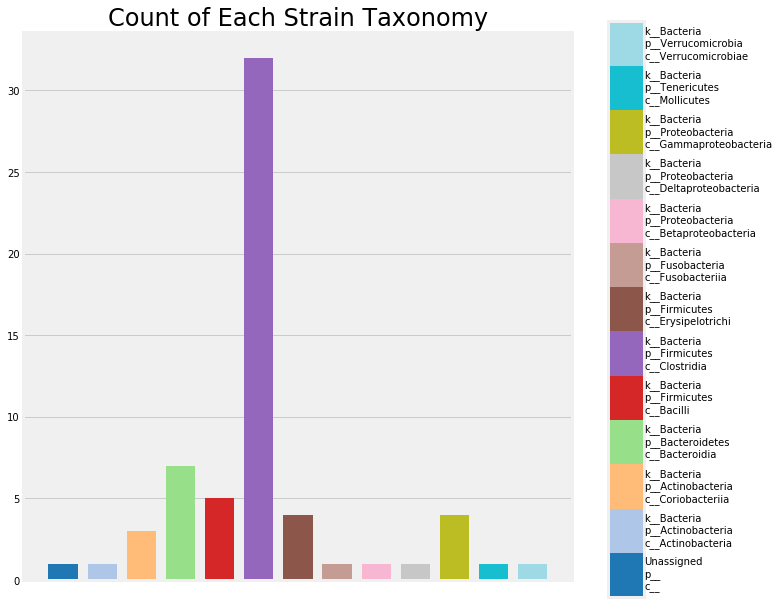

In [47]:
fig, ax = plt.subplots(figsize=(10, 8))
bar_width = 0.750
rects1 = ax.bar(np.arange(len(labels)), counts[0], bar_width, color=colors)
sm = ScalarMappable(cmap=cmap)
sm.set_array([])
ax.set_xticks([])
plt.tight_layout()
plt.title('Count of Each Strain Taxonomy', fontsize=24)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.0, 0.05, 1])
cb = plt.colorbar(sm, cax=cbar_ax)
cb.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(labels):
    cb.ax.text(1, (2 * j + 1) / 26.0, lab, ha='left', va='center', fontsize=10)

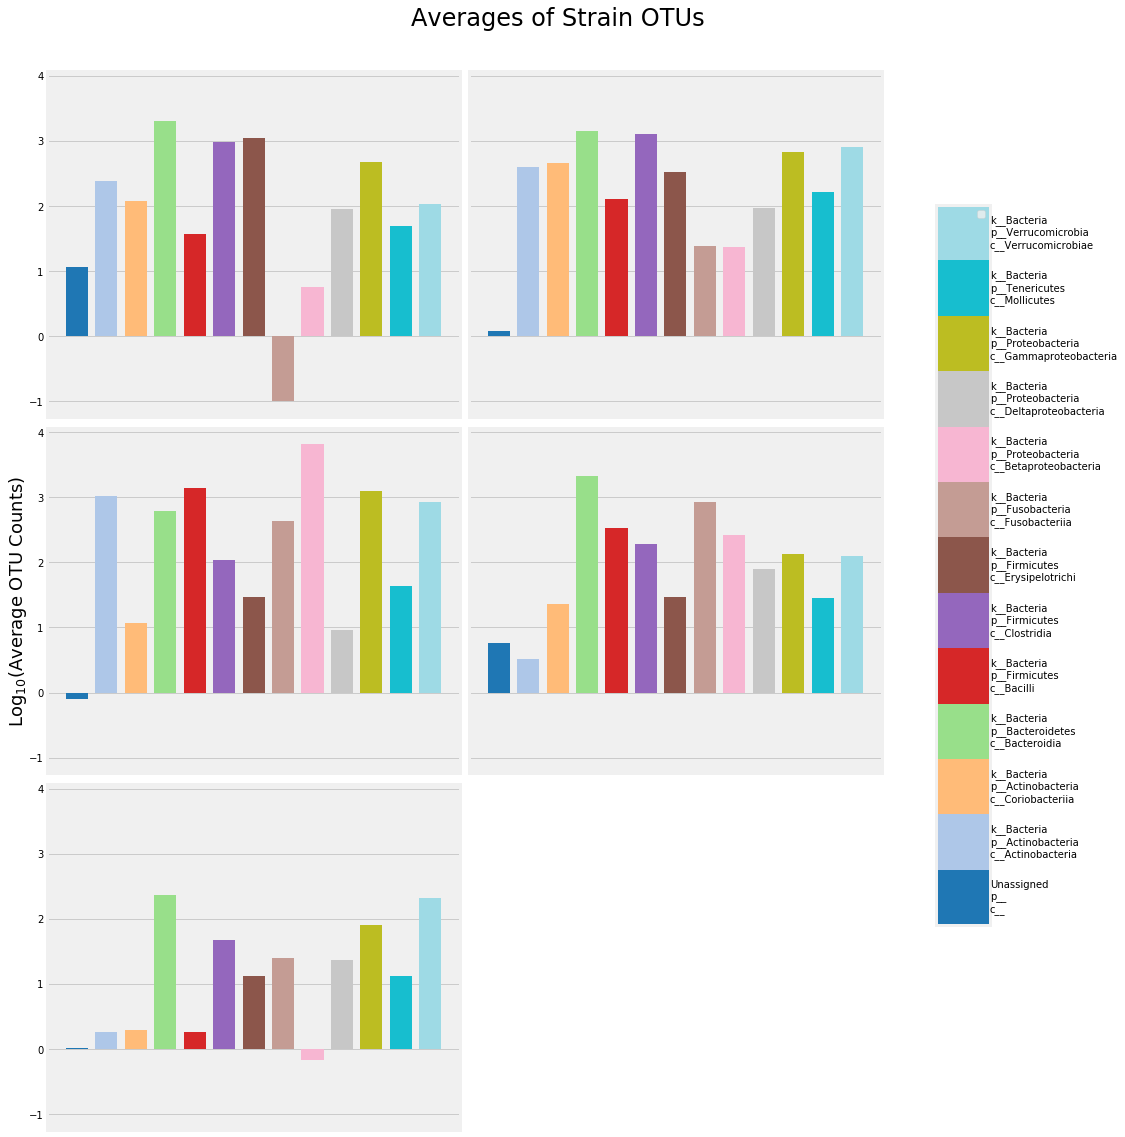

In [52]:

fig, ax = plt.subplots(num_rows, num_cols, figsize=(subplot_width, subplot_height), 
                       sharex=True, sharey=True)
axl = ax.flatten()

for i, c in enumerate(counts):
    bar_width = 0.750
    rects1 = axl[i].bar(np.arange(len(labels)), np.log10(means[i]), bar_width, color=colors)
    sm = ScalarMappable(cmap=cmap)
    sm.set_array([])
    axl[i].set_xticks([])
    plt.tight_layout()

# This is all to get the colorbar on the right.
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, colorbar_start, 0.05, colorbar_height])
cb = plt.colorbar(sm, cax=cbar_ax)
cb.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(labels):
    cb.ax.text(1, (2 * j + 1) / 26.0, lab, ha='left', va='center', fontsize=10)

plt.suptitle('Averages of Strain OTUs', y=1.05, fontsize=24)
plt.legend(loc='upper right')
fig.text(-0.01, 0.5, 'Log$_{10}$(Average OTU Counts)', va='center', rotation='vertical', fontsize=18)

# Cleanup
if num_rows * num_cols != len(oh.samples):
    ax[-1, -1].axis('off')
    
plt.show()

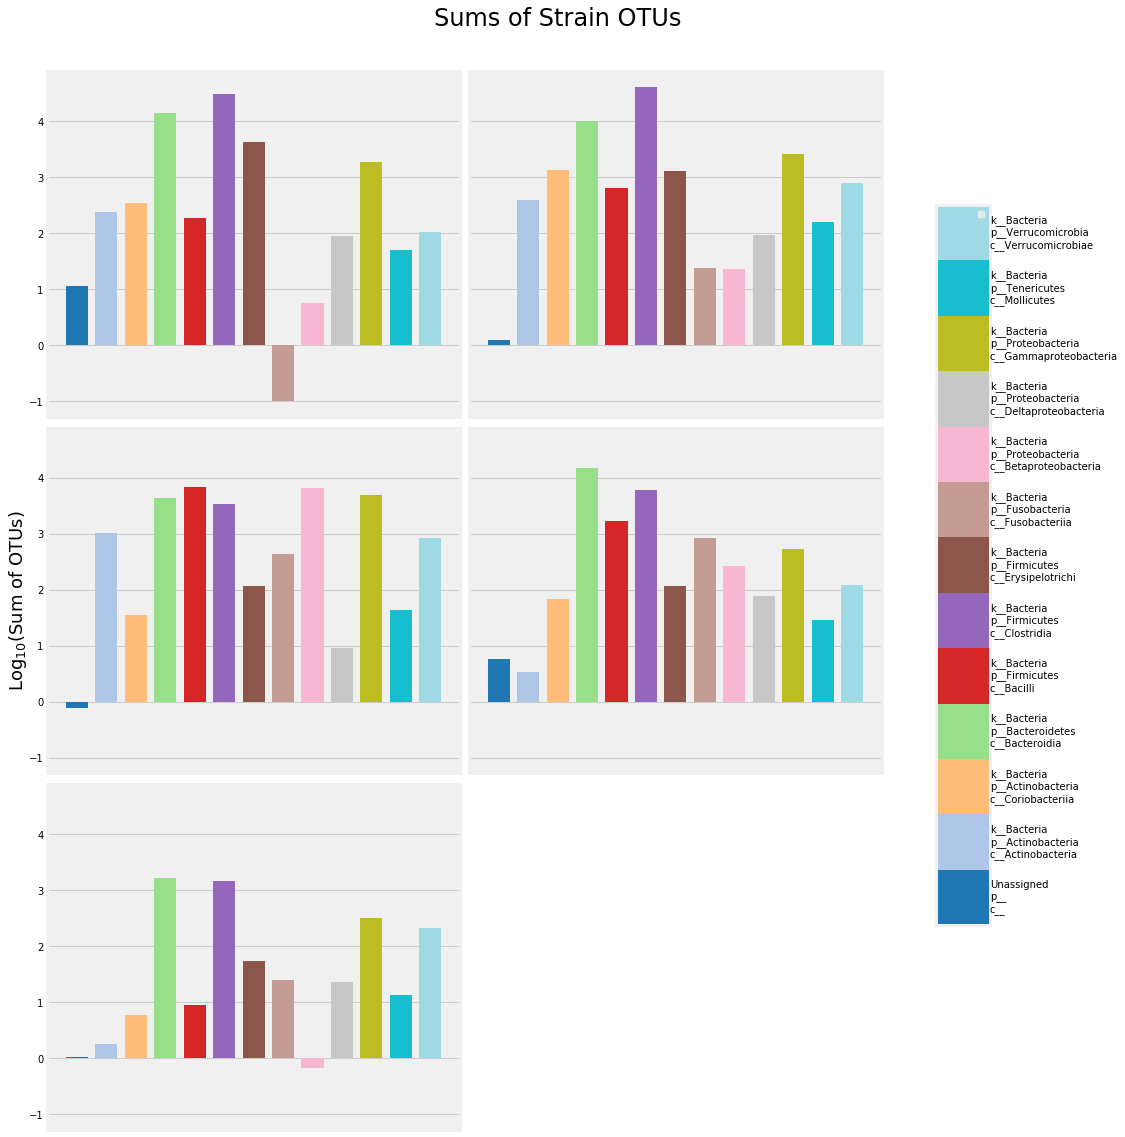

In [51]:
fig, ax = plt.subplots(num_rows, num_cols, figsize=(subplot_width, subplot_height), sharex=True, sharey=True)
axl = ax.flatten()

for i, c in enumerate(counts):
    bar_width = 0.750
    rects1 = axl[i].bar(np.arange(len(labels)), np.log10(sums[i]), bar_width, color=colors)
    sm = ScalarMappable(cmap=cmap)
    sm.set_array([])
    axl[i].set_xticks([])
    plt.tight_layout()

# This is all to get the colorbar on the right.
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, colorbar_start, 0.05, colorbar_height])
cb = plt.colorbar(sm, cax=cbar_ax)
cb.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(labels):
    cb.ax.text(1, (2 * j + 1) / 26.0, lab, ha='left', va='center', fontsize=10)

plt.suptitle('Sums of Strain OTUs', y=1.05, fontsize=24)
plt.legend(loc='upper right')
fig.text(-0.01, 0.5, 'Log$_{10}$(Sum of OTUs)', va='center', rotation='vertical', fontsize=18)

# Cleanup
if num_rows * num_cols != len(oh.samples):
    ax[-1, -1].axis('off')
plt.show()

# Cosine distance between samples
Given the discrepancies between the samples as seen above, let's get a more concrete measure of their difference.

In [14]:
# Take the mean over time of each sample

donor_means = [s.mean(axis=1) for s in oh.samples]
donor_means = [m / (1.0 * m.sum()) for m in donor_means]


In [20]:
# Empty array for our distances
dists = np.zeros((len(donor_means), len(donor_means)))
for i in range(len(donor_means)):
    for j in range(len(donor_means)):
        if i < j:
            dists[i, j] = None
        else:
            dists[i, j] = cosine(donor_means[i], donor_means[j])

Text(0.5,1.2,'Cosine Distances Between the\nNormalize Means of OTU Counts')

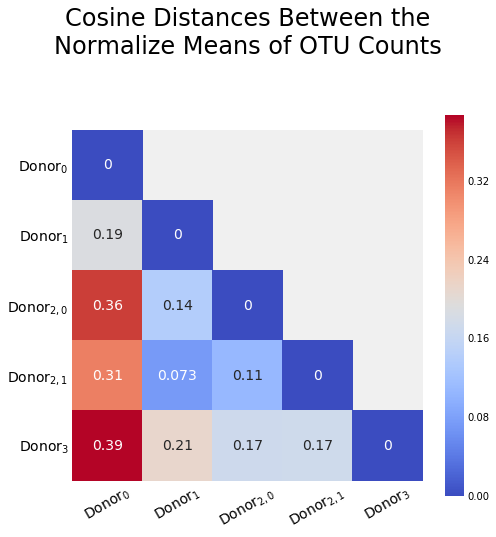

In [23]:
plt.figure(figsize=(7, 7))


ax = sns.heatmap(dists, 
            cmap='coolwarm', 
            vmax=np.nanmax(dists), 
            vmin=0,
            square=True,
            annot=dists,
            yticklabels=file_labs,
            xticklabels=file_labs,
                annot_kws={'fontsize': 14})
plt.yticks(rotation=0, fontsize=14)
# ax.xaxis.set_ticks_position('top')
plt.xticks(rotation=30, fontsize=14)
plt.title('Cosine Distances Between the\nNormalize Means of OTU Counts',
          y=1.2, fontsize=24)

# Perform PCA on Input

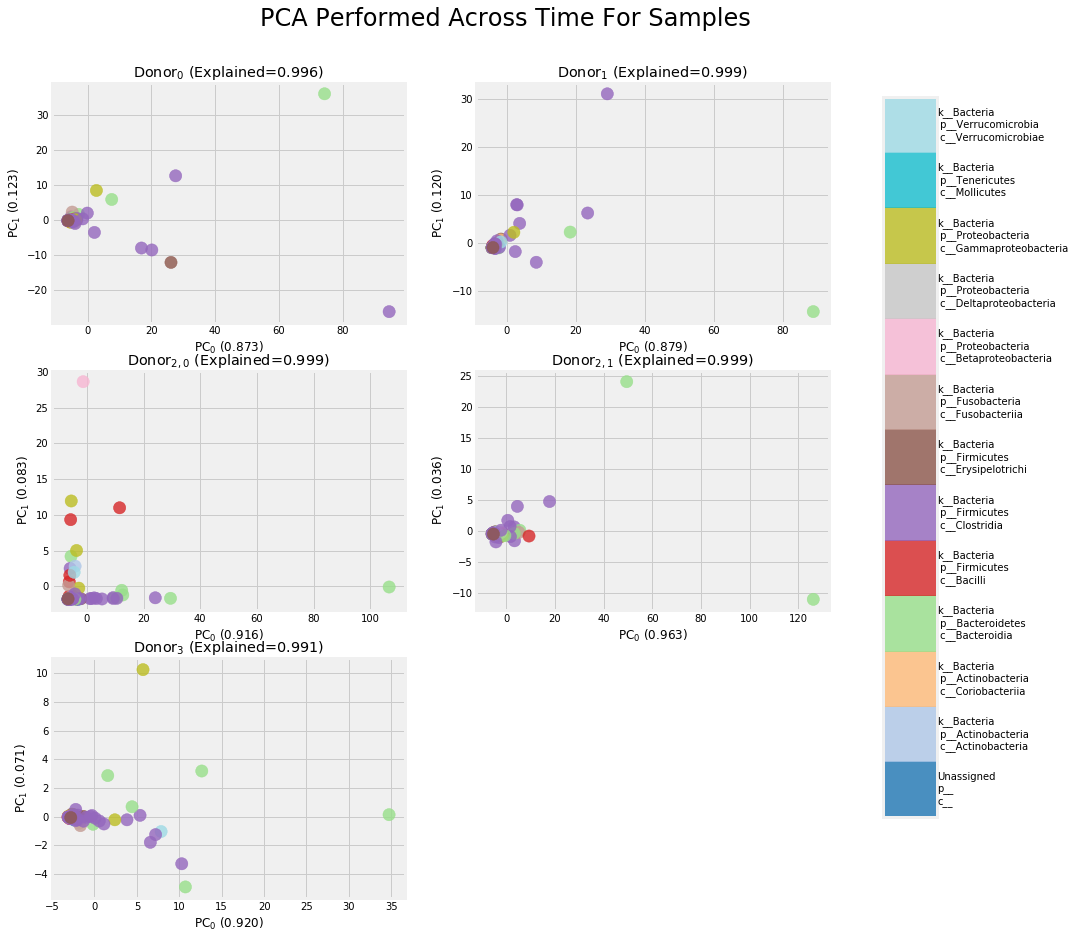

In [17]:
%matplotlib inline
num_samples = len(oh.samples)
fig, ax = plt.subplots(num_rows, num_cols, figsize=(subplot_height, subplot_width), sharex=False, sharey=False)
axl = ax.flatten()
for i, s in enumerate(oh.samples):
    zs = zscore(s.values, axis=0)
    pca = PCA(n_components=2)
    pca.fit(zs)
    t = pca.transform(zs)
    x_vals = t[:, 0]
    y_vals = t[:, 1]
    sc = axl[i].scatter(x_vals, y_vals, c=labs_to_ints, cmap=cmap, s=150, alpha=0.8)
    axl[i].set_title('{} (Explained={})'.format(file_labs[i], 
                                               str(sum(pca.explained_variance_ratio_[:2]))[:5]
                                              ))
    axl[i].set_xlabel('PC$_0$ ({})'.format(str(pca.explained_variance_ratio_[0])[:5]))
    axl[i].set_ylabel('PC$_1$ ({})'.format(str(pca.explained_variance_ratio_[1])[:5]))
    
    # Uncommenting this will annotate each point so that you can see which it is to remove it later potentially.
#     for j, txt in enumerate(full_labs):
#         axl[i].annotate(txt, (x_vals[j], y_vals[j]), fontsize=6)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, colorbar_start, 0.05, colorbar_height])
# fig.colorbar(im, cax=cbar_ax)
cb = plt.colorbar(sc, cax=cbar_ax)
cb.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(labels):
    cb.ax.text(1, (2 * j + 1) / 26.0, lab, ha='left', va='center', fontsize=10)
plt.suptitle('PCA Performed Across Time For Samples', fontsize=24, y=0.95)

# Cleanup
if num_rows * num_cols != len(oh.samples):
    ax[-1, -1].axis('off')

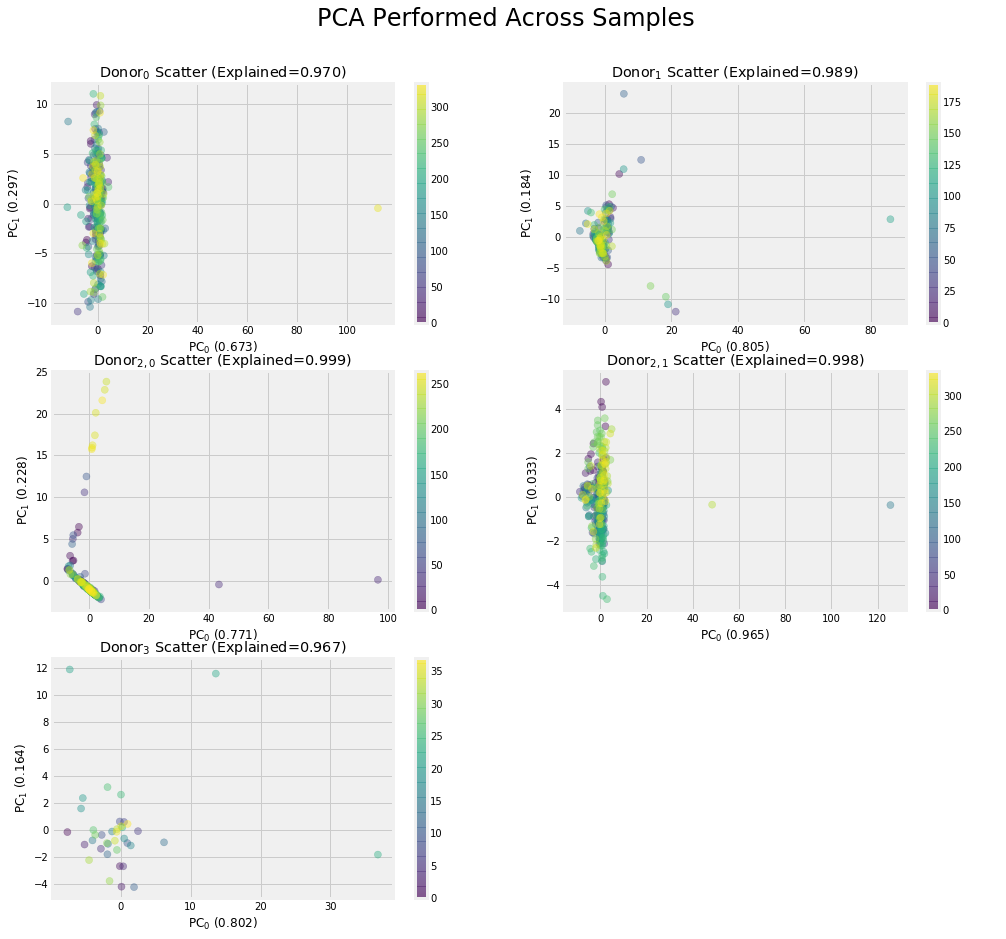

In [18]:

fig, ax = plt.subplots(num_rows, num_cols, figsize=(subplot_height, subplot_width), sharex=False, sharey=False)
axl = ax.flatten()
for i, s in enumerate(oh.samples):
    zs = zscore(s.values, axis=1).T
    pca = PCA(n_components=2)
    pca.fit(zs)
    t = pca.transform(zs)
    sc = axl[i].scatter(t[:, 0], t[:, 1], c=range(t.shape[0]), cmap='viridis', s=50, alpha=0.4)
    axl[i].set_title('{} Scatter (Explained={})'.format(file_labs[i], 
                                                       str(sum(pca.explained_variance_ratio_[:2]))[:5]
                                                      ))
    axl[i].set_xlabel('PC$_0$ ({})'.format(str(pca.explained_variance_ratio_[0])[:5]))
    axl[i].set_ylabel('PC$_1$ ({})'.format(str(pca.explained_variance_ratio_[1])[:5]))
    cb = plt.colorbar(sc, ax=axl[i])
plt.suptitle('PCA Performed Across Samples', fontsize=24, y=0.95)

# Cleanup
if num_rows * num_cols != len(oh.samples):
    ax[-1, -1].axis('off')
plt.show()